## Bellis's Lecture

https://colab.research.google.com/drive/12LHs9cL8-gXKr_ypaNfnwaO9bLF3I9tQ?usp=sharing

In [1]:
%load_ext autoreload
%autoreload 2


import uproot
import awkward as ak
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns

import time

from hist import Hist

import babar_analysis_tools as bat
from analysis_variables import *
import myPIDselector

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
start= time.time()

## My laptop
#topdir= "/Users/josieswann/BaBar_analyses/BNV_pLambda/"

## Bellis computer
#topdir= "/home/bellis/babar_data/bnv_plambda"
topdir= "/home/bellis/babar_data/bnv_plambda_bnc"


#filename= f"{topdir}/Background_and_signal_SP_modes_Only_Run_1.parquet"
#filename= f"{topdir}/Background_and_signal_SP_modes_All_runs.parquet" ## this won't run on mine 
#filename= f"{topdir}/Background_and_signal_SP_modes_BNC_Only_Run_1.parquet"
filename= f"{topdir}/Background_and_signal_SP_modes_BNC_All_runs.parquet"

data= ak.from_parquet(filename)

print(f"Took {time.time()-start} seconds")

IS_MC= True

#Collision data 

#filename = f'{topdir}/Background_SP_modes_Only_Run_1.parquet'
#filename = f'{topdir}/Data_Only_Run_1_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'
#filename = f'{topdir}/Data_BNC_Only_Run_1.parquet'
filename = f'{topdir}/Data_BNC_All_runs.parquet'

start= time.time()
data_collision= ak.from_parquet(filename)

print(f"took {time.time()-start} seconds")

print(type(data_collision))


Took 311.68008518218994 seconds
took 93.60842370986938 seconds
<class 'awkward.highlevel.Array'>


## Cross section info - scaling values 

In [3]:
dataset_information= pd.read_csv("dataset_statistics.csv")
cs_data= pd.read_csv("SP_cross_sections_and_labels.csv")

no_notes= cs_data.drop(["Uncertainty","Note: cross sections found at https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/Cross_sections,_luminosities,_and_other_vital_stats"], axis= 1)
no_notes

,SP Mode,Human-readable explamanation,LaTeX output,Cross section [nb]
0,1235,B+B- pairs,$B^+ B^-$,0.525
1,1237,B0 B0bar pairs,$B^0\overline{B^0}$,0.525
2,1005,ccbar,$c\bar{c}$,1.300
3,998,uubar/ddbar/ssbar,"$u\bar{u}, d\bar{d}, c\bar{c}$",2.090
4,2400,bhabha- e+e- to e+e-,$e^+e^-$,40.000
5,3429,tau+tau-,$\tau^+\tau^-$,0.919
6,3981,mu+mu- gamma,$\mu^+\mu^-\gamma$,1.147


## SP info and Region Defs

In [4]:
sp= data["spmode"]

splist= np.unique(sp.to_list())
splist

array(['-999', '1005', '1235', '1237', '3429', '998'], dtype='<U4')

In [5]:
region_definitions

{'Area': ['Fitting area', 'Signal area'],
 'signal MES': [5.27, 5.3],
 'fitting MES': [5.2, 5.3],
 'signal DeltaE': [-0.07, 0.07],
 'fitting DeltaE': [-0.2, 0.2],
 'sideband 1 DeltaE': [0.07, 0.14],
 'sideband 2 DeltaE': [-0.14, -0.07],
 'sideband MES': [5.27, 5.3],
 'inference': [[5.27, 5.3, -0.07, 0.07],
  [5.27, 5.3, -0.2, -0.07],
  [5.27, 5.3, 0.07, 0.2],
  [5.25, 5.27, -0.2, 0.0],
  [5.25, 5.27, 0.0, 0.2],
  [5.23, 5.25, -0.2, 0.0],
  [5.23, 5.25, 0.0, 0.2],
  [5.2, 5.23, -0.2, 0.0],
  [5.2, 5.23, 0.0, 0.2]],
 'Lambda0 mass': [1.112683, 1.1186829999999999],
 'Lambda0 flightlen': 1.0}

## Tag Side B (ask about this)

In [6]:
bat.fill_new_entry_with_tag_side_B(data)
data["BtagSideMes"]


/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


<Array [5.13, 5.07, 5.13, 4.75, ..., 5.26, 5.21, 5.1] type='1094971 * float64'>

In [7]:
bat.fill_new_entry_with_tag_side_B(data_collision)
data_collision["BtagSideMes"]


<Array [3.93, 4.82, 5.2, 5.28, ..., 4.12, 5.27, 5.28] type='724800 * float64'>

In [8]:
all_hists= bat.create_empty_histograms(hist_defs)

bkg_spmodes= ["998","1005","3981","1235","1237"]
sig_spmodes= ["-999"]

spmodes= bkg_spmodes+sig_spmodes

weights= {}
for sp in spmodes: 
    weights[sp]= bat.scaling_value(int(sp),dataset_information=dataset_information, cs_data= cs_data, plot= False, verbose= False)
    #weights[sp]=1

weights["-999"]= 1000 #scales signal higher 
weights["0"]= 1 #idk what this is for;;; ASK

print(weights)

{'998': 0.2506879075487834, '1005': 0.49619965664110677, '3981': 0.7950555869080849, '1235': 0.3191592629119508, '1237': 0.31492522877218293, '-999': 1000, '0': 1}


## Making the masks 

In [9]:
dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

print([dcuts.keys()])
print()

for key in dcuts.keys():
    print(f'{key:3d} {dcuts[key]["name"]}')

dcuts[3]

[dict_keys([1, 2, 3, 4, 6, -1])]

  1 cut duplicates
  2 fitting region
  3 Lambda0 cuts / nB / nLambda
  4 PID cuts
  6 antiproton cuts
 -1 all


{'name': 'Lambda0 cuts / nB / nLambda',
 'event': array([ True,  True, False, ...,  True,  True,  True]),
 'candidates': <Array [[True], [True], ..., [True], [True]] type='1072872 * var * bool'>}

In [10]:
#mask_event= dcuts[1]["event"]
#mask_event= dcuts[2]["event"]
mask_event= dcuts[3]["event"]
#mask_event= dcuts[4]["event"] ## individual cuts
#mask_event= dcuts[-1]["event"] ## all cuts

#mask_event= dcuts[1]["event"] & dcuts[2]["event"] & dcuts[3]["event"] & dcuts[4]["event"] ## combo of cuts
mask_event= dcuts[1]["event"] & dcuts[2]["event"] & dcuts[3]["event"] ## combo of cuts

### ASK WHAT THESE MEAN
#tag= "EARLY_CUT"
tag= "FINAL_CUTS"

mask= mask_event

In [180]:
#data.fields

['runNumber',
 'platform',
 'partition',
 'upperID',
 'lowerID',
 'majorID',
 'configKey',
 'date',
 'ddate',
 'eePx',
 'eePy',
 'eePz',
 'eeE',
 'beamSX',
 'beamSY',
 'beamSZ',
 'beamSCovXX',
 'beamSCovYY',
 'beamSCovZZ',
 'beamSCovXZ',
 'nTracks',
 'nGoodTrkLoose',
 'nChargedTracks',
 'R2',
 'R2All',
 'thrustMag',
 'thrustMagAll',
 'thrustCosTh',
 'thrustCosThAll',
 'thrustPhi',
 'thrustPhiAll',
 'sphericityAll',
 'mcLen',
 'mcLund',
 'mothIdx',
 'dauLen',
 'dauIdx',
 'mcmass',
 'mcp3CM',
 'mccosthCM',
 'mcphiCM',
 'mcenergyCM',
 'mcp3',
 'mccosth',
 'mcphi',
 'mcenergy',
 'mcVtxx',
 'mcVtxy',
 'mcVtxz',
 'nB',
 'BChi2',
 'BCosSphr',
 'BCosThetaS',
 'BCosThetaT',
 'BCosThrust',
 'BLegendreP0',
 'BLegendreP2',
 'BMass',
 'BMassErr',
 'BPFlow0',
 'BPFlow1',
 'BPFlow2',
 'BPFlow3',
 'BPFlow4',
 'BPFlow5',
 'BPFlow6',
 'BPFlow7',
 'BPFlow8',
 'BR2ROE',
 'BSphr',
 'BSphrROE',
 'BThrust',
 'BThrustROE',
 'BVtxx',
 'BVtxy',
 'BVtxz',
 'B_con_Chi2',
 'B_con_Mass',
 'B_con_MassErr',
 'B_con_V

In [11]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out

df_out



,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
0,998,5.263783,-0.189936,1.116111,5.128820,0.005330,0.998314,0.464635,0.454394,0.419195,...,0.277930,0.397070,0.110201,-0.509205,-0.366883,0.520370,1.097943,0.169009,0.411743,0.715501
1,998,5.211709,-0.054256,1.115692,5.073468,0.003054,0.998590,-0.988520,0.500206,0.449933,...,0.670107,0.709401,0.100613,0.711723,0.991103,0.733522,4.020535,0.203065,0.444210,0.740848
2,998,5.205639,-0.095738,1.114520,4.510577,0.039430,0.982052,0.994756,0.925238,0.887027,...,0.140156,0.148416,0.030029,0.117417,0.992060,0.108286,2.378769,0.887218,0.003017,0.972584
3,998,5.244567,-0.052588,1.114744,5.182759,0.013351,0.990498,0.523062,0.591105,0.356842,...,0.750955,0.793746,0.166007,0.821093,0.909180,0.820298,1.454894,0.160212,0.600114,0.653028
4,998,5.215815,0.050270,1.117489,5.260328,0.011017,0.989456,0.943788,0.683442,0.658670,...,0.118271,0.146456,0.063063,0.026921,-0.924347,0.016714,3.028776,0.520410,0.222310,0.883328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168889,-999,5.279527,0.033336,1.114953,5.284737,0.004968,0.996235,0.691058,0.385213,0.315803,...,0.039638,0.030412,0.217225,0.138832,-0.656168,0.116068,1.932471,0.185726,0.344503,0.739092
168890,-999,5.275526,0.000239,1.114017,5.243846,0.012021,0.995474,0.085707,0.341070,0.222305,...,0.619186,0.570975,0.248629,0.589459,0.070907,0.586688,0.550932,0.229605,0.322895,0.774997
168891,-999,5.276882,-0.037394,1.114870,5.257199,0.012876,0.988566,-0.329969,0.341776,0.277969,...,0.064506,0.102459,0.355454,0.119290,0.336818,0.115901,0.931738,0.612370,0.093815,0.910479
168892,-999,5.278979,0.003463,1.116391,5.210315,0.005293,0.997421,-0.586439,0.337755,0.299489,...,0.621333,0.599540,0.179411,-0.453241,0.365380,0.461186,1.063949,0.203228,0.327322,0.766174


In [189]:
# Testing out the autowrite out to dataframe
d = data[dcuts[-1]['event']]

subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']


df_test = bat.dump_awkward_to_dataframe(d, fields_to_dump=subset)

df_test

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
0,998,5.263783,-0.189936,1.116111,5.128820,0.005330,0.998314,0.464635,0.454394,0.419195,...,0.277930,0.397070,0.110201,-0.509205,-0.366883,0.520370,1.097943,0.169009,0.411743,0.715501
1,998,5.266822,0.071653,1.114958,4.803124,0.007929,0.996128,0.999159,0.843386,0.739316,...,0.483429,0.473835,0.042020,0.523045,0.993581,0.490052,5.729906,0.577522,0.081948,0.891275
2,998,5.252054,-0.159159,1.116168,5.126067,0.009145,0.992343,0.862500,0.498796,0.456163,...,0.553191,0.568595,0.175014,0.440903,0.868596,0.430949,2.985317,0.276234,0.564575,0.774439
3,998,5.237349,-0.078162,1.115801,4.852676,0.004979,0.997970,0.938271,0.985204,0.759432,...,0.098739,0.179611,0.050164,-0.085701,0.950139,0.104763,2.664766,0.577619,0.064268,0.900341
4,998,5.226675,0.075255,1.116105,5.141896,0.027592,0.990130,-0.865809,0.647735,0.668491,...,0.586964,0.466396,0.057357,-0.481098,0.846028,0.487858,2.017789,0.507923,0.061927,0.858213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29047,-999,5.279527,0.033336,1.114953,5.284737,0.004968,0.996235,0.691058,0.385213,0.315803,...,0.039638,0.030412,0.217225,0.138832,-0.656168,0.116068,1.932471,0.185726,0.344503,0.739092
29048,-999,5.275526,0.000239,1.114017,5.243846,0.012021,0.995474,0.085707,0.341070,0.222305,...,0.619186,0.570975,0.248629,0.589459,0.070907,0.586688,0.550932,0.229605,0.322895,0.774997
29049,-999,5.276882,-0.037394,1.114870,5.257199,0.012876,0.988566,-0.329969,0.341776,0.277969,...,0.064506,0.102459,0.355454,0.119290,0.336818,0.115901,0.931738,0.612370,0.093815,0.910479
29050,-999,5.278979,0.003463,1.116391,5.210315,0.005293,0.997421,-0.586439,0.337755,0.299489,...,0.621333,0.599540,0.179411,-0.453241,0.365380,0.461186,1.063949,0.203228,0.327322,0.766174


In [12]:
df.groupby("spmode").count()

,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BtagSideMes,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
spmode,,,,,,,,,,,,,,,,,,,,,
-999,37578,37578,37578,37541,37578,37578,37578,37578,37578,37578,...,37578,37578,37578,37578,37578,37578,37578,37578,37578,37578
1005,35120,35120,35120,35086,35120,35120,35120,35120,35120,35120,...,35120,35120,35120,35120,35120,35120,35120,35120,35120,35120
1235,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
1237,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
3429,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
998,96118,96118,96118,96010,96118,96118,96118,96118,96118,96118,...,96118,96118,96118,96118,96118,96118,96118,96118,96118,96118


In [13]:
df.columns

Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168894 entries, 0 to 168893
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   spmode            168894 non-null  object 
 1   BpostFitMes       168894 non-null  float32
 2   BpostFitDeltaE    168894 non-null  float32
 3   Lambda0_unc_Mass  168894 non-null  float32
 4   BtagSideMes       168715 non-null  float64
 5   BSphr             168894 non-null  float32
 6   BThrust           168894 non-null  float32
 7   BCosThetaS        168894 non-null  float32
 8   R2                168894 non-null  float32
 9   R2All             168894 non-null  float32
 10  thrustMag         168894 non-null  float32
 11  thrustMagAll      168894 non-null  float32
 12  thrustCosTh       168894 non-null  float32
 13  thrustCosThAll    168894 non-null  float32
 14  sphericityAll     168894 non-null  float32
 15  BCosSphr          168894 non-null  float32
 16  BCosThetaT        16

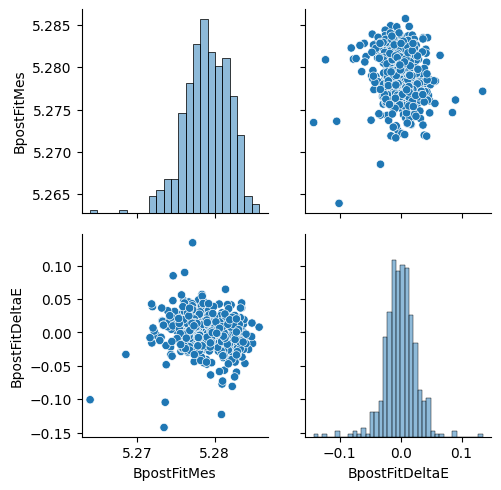

In [15]:
filter= df["spmode"]== "-999"

g= sns.PairGrid(df[filter].sample(500), vars= ["BpostFitMes","BpostFitDeltaE"], hue= "spmode")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [16]:
columns= df.columns
columns

Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass',
       'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All',
       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',
       'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2',
       'BR2ROE', 'BSphrROE', 'BThrustROE'],
      dtype='object')

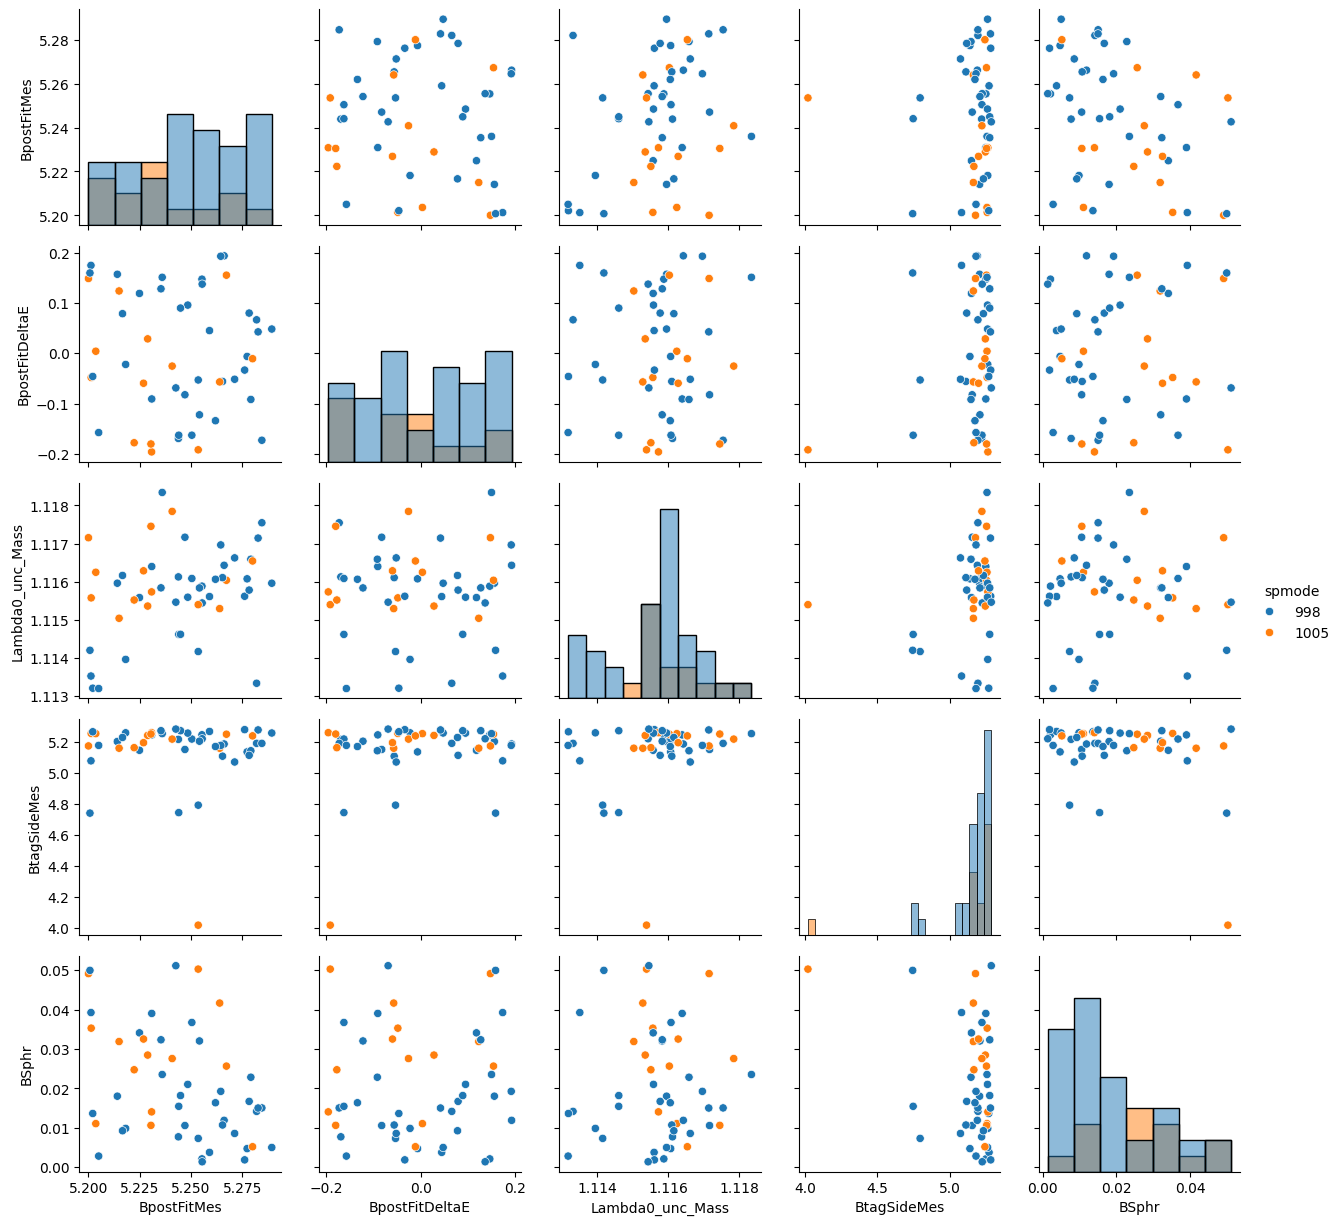

In [17]:
filter = df['spmode'] != '-999'

#g = sns.PairGrid(df[filter].sample(500), vars=['BpostFitMes', 'BpostFitDeltaE'], hue='spmode')
g = sns.PairGrid(df[filter].sample(50), vars=columns[1:6], hue='spmode')

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Neural Net

In [18]:
feature_names= columns[1:] ##exclude spmode
print(feature_names)

Index(['BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', 'BtagSideMes',
       'BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All', 'thrustMag',
       'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll',
       'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE',
       'BSphrROE', 'BThrustROE'],
      dtype='object')


In [19]:
df.groupby("spmode").count()["R2"] ## R2 doesn't matter we just want to see how many of each sp mode are there

spmode
-999    37578
1005    35120
1235       25
1237       33
3429       20
998     96118
Name: R2, dtype: int64

In [20]:
filter_sig= df["spmode"]== "-999"
filter_bkg= df["spmode"]== "998"

# Run 1
#df_sig= df[filter_sig].dropna().sample(1000)
#df_bkg= df[filter_bkg].dropna().sample(1000)

# All runs
df_sig= df[filter_sig].dropna().sample(20000)
df_bkg= df[filter_bkg].dropna().sample(20000)



df_ML= pd.concat([df_sig,df_bkg])

x= df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"])

y=df_ML["spmode"]

In [21]:
feature_names= x.columns ##disc vars
labels= y.unique() ##diff sp modes

print("Training features:")
print(feature_names)
print()

print("Labels (Outcome):")
print(labels)
print()

print("The dataset (x) is the numbers without column names---")
print("The variable y is truth info about the data (signal or bkg)")

Training features:
Index(['BSphr', 'BThrust', 'BCosThetaS', 'R2', 'R2All', 'thrustMag',
       'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll',
       'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE',
       'BSphrROE', 'BThrustROE'],
      dtype='object')

Labels (Outcome):
['-999' '998']

The dataset (x) is the numbers without column names---
The variable y is truth info about the data (signal or bkg)


In [22]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.4, random_state= 4)


In [23]:
x_test

,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,thrustMagAll,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
41634,0.006447,0.993347,0.979063,0.807035,0.803695,0.961472,0.960874,0.063189,0.056958,0.038291,-0.020130,-0.981543,0.047394,4.858075,0.711575,0.046604,0.939187
164291,0.010188,0.994065,-0.500540,0.429113,0.309767,0.822414,0.769733,0.289929,0.290680,0.214655,0.425011,-0.342731,0.437414,1.266764,0.229838,0.369549,0.778739
152062,0.010197,0.986418,0.660638,0.306442,0.303235,0.797075,0.797951,0.039191,0.032540,0.170328,0.318118,-0.735654,0.308441,2.086984,0.135595,0.575505,0.719000
58282,0.047814,0.983640,0.921721,0.629168,0.629072,0.919427,0.922140,0.148051,0.207430,0.119569,-0.086633,0.899920,0.080250,3.747310,0.549557,0.200014,0.904146
151227,0.003719,0.995879,0.004842,0.251886,0.243225,0.751970,0.745980,0.288712,0.269674,0.243547,0.392843,-0.224427,0.373313,1.790968,0.041344,0.650523,0.599509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37498,0.001752,0.998144,0.988907,0.805276,0.708761,0.962953,0.939904,0.402532,0.388321,0.067376,0.331988,0.981705,0.321235,3.397450,0.476406,0.208761,0.877613
64587,0.004372,0.995763,0.288781,0.616097,0.190083,0.907051,0.710069,0.747111,0.727603,0.211526,0.757301,0.239867,0.753527,1.076534,0.177168,0.480326,0.728671
75474,0.017415,0.992193,0.778062,0.529885,0.515393,0.888300,0.884720,0.030292,0.043519,0.167180,0.223887,-0.807942,0.217855,2.454995,0.412297,0.209961,0.838135
14062,0.006683,0.996088,0.826663,0.571549,0.580129,0.885663,0.901634,0.316464,0.296459,0.143086,0.158800,0.816624,0.149958,2.644010,0.309417,0.202189,0.809389


In [24]:
x_train

,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,thrustMagAll,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
30026,0.008891,0.996732,0.968431,0.616466,0.485077,0.913880,0.869358,0.589691,0.511605,0.143300,-0.508077,0.998917,0.500615,2.629362,0.150583,0.478775,0.731225
22098,0.029282,0.987697,0.924401,0.718924,0.499148,0.939963,0.876564,0.895003,0.891736,0.108945,0.874913,0.964304,0.868169,1.847454,0.257753,0.242148,0.782603
149586,0.014195,0.993719,0.936043,0.521731,0.415787,0.888058,0.836891,0.815960,0.747938,0.197916,0.781094,0.949265,0.777452,2.086106,0.182803,0.643073,0.728094
141457,0.008793,0.996967,0.786796,0.531145,0.426972,0.866425,0.828917,0.570545,0.574468,0.159306,0.550765,0.652064,0.529984,2.131284,0.226582,0.414601,0.757101
86797,0.036400,0.974559,0.961421,0.460000,0.433339,0.847787,0.846936,0.380400,0.347104,0.190935,0.314068,0.915475,0.331443,2.910011,0.237353,0.518332,0.753193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51589,0.014375,0.983805,0.974396,0.799794,0.684305,0.961817,0.927133,0.450104,0.455668,0.057693,-0.375798,0.963468,0.377667,2.658485,0.476449,0.209730,0.868209
139754,0.012896,0.990798,-0.633200,0.338149,0.236791,0.824581,0.763779,0.240002,0.163610,0.175897,-0.095066,0.548211,0.088347,1.244126,0.154489,0.694979,0.688900
79426,0.017308,0.991617,0.828066,0.326131,0.342571,0.791501,0.794567,0.100546,0.186398,0.174071,0.463808,-0.722973,0.451662,2.524998,0.137993,0.509958,0.705216
163979,0.004202,0.997413,0.958530,0.562066,0.487720,0.890138,0.866635,0.010725,0.038543,0.111650,-0.055316,-0.857612,0.062869,2.638342,0.222288,0.453032,0.751435


In [25]:
y_test

41634      998
164291    -999
152062    -999
58282      998
151227    -999
          ... 
37498      998
64587      998
75474      998
14062      998
166841    -999
Name: spmode, Length: 16000, dtype: object

In [26]:
y_train

30026      998
22098      998
149586    -999
141457    -999
86797      998
          ... 
51589      998
139754    -999
79426      998
163979    -999
154574    -999
Name: spmode, Length: 24000, dtype: object

In [27]:
'''
scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)
'''

'\nscaler= StandardScaler()\nx_train= scaler.fit_transform(x_train)\nx_test= scaler.transform(x_test)\n'

In [28]:
y_train

30026      998
22098      998
149586    -999
141457    -999
86797      998
          ... 
51589      998
139754    -999
79426      998
163979    -999
154574    -999
Name: spmode, Length: 24000, dtype: object

In [29]:
print(len(y_train[y_train=='-999']))
print(len(y_train[y_train=='998']))

## This should be about half and half since we used the same amount of data for each case (sig and bkg)

11963
12037


In [30]:
# Making the Neural Network Classifier
model = MLPClassifier(max_iter= 300, random_state= 3, activation= "relu", solver= "adam") #n_iter_no_change= 15)
#model = RandomForestClassifier() #n_iter_no_change= 15)

# Training the model on the training data and labels
model.fit(x_train, y_train)

MLPClassifier(max_iter=300, random_state=3)

In [31]:
# Testing the model i.e. predicting the labels of the test data.
y_pred = model.predict(x_test)

# Evaluating the results of the model
accuracy = accuracy_score(y_test,y_pred)*100 ### returns the fraction of correctly classified samples 
confusion_mat = confusion_matrix(y_test,y_pred)

In [32]:
print("Accuracy for Neural Network is:",accuracy)
print("Confusion Matrix")
print(confusion_mat)

tot_correct= confusion_mat[1][1] + confusion_mat[0][0]
tot_wrong= confusion_mat[1][0] + confusion_mat[0][1]

#print(tot_correct/(tot_correct+tot_wrong))

## The accuracy score is the total number classified correctly over the total number of classifications 


Accuracy for Neural Network is: 86.05625
Confusion Matrix
[[6793 1244]
 [ 987 6976]]


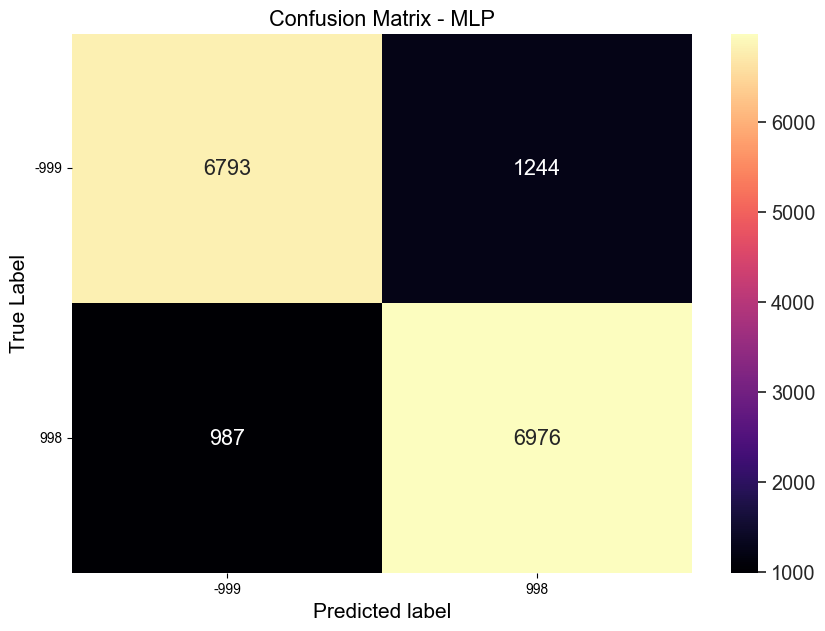

In [33]:
# Turn this into a dataframe
matrix_df = pd.DataFrame(confusion_mat)

# Plot the result
fig, ax = plt.subplots(figsize=(10,7))

sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")

#labels = df['target_names'].tolist()
#labels = ['998', '-999'] # NEED TO FIX THIS SO IT IS NOT HARDCODED

# Formatting details here
# Set axis titles
ax.set_title('Confusion Matrix - MLP')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(labels, rotation = 0)
plt.show()

[array([0.7129101 , 0.9917887 , 0.9773687 , ..., 0.9404287 , 0.93191195,
       0.34923017], dtype=float32), array([0.8665714 , 0.3084731 , 0.08249448, ..., 0.05634311, 0.433866  ,
       0.31835055], dtype=float32), array([0.94814074, 0.99742496, 0.41759893, ..., 0.07538079, 0.54164916,
       0.38451952], dtype=float32), array([0.03417635, 0.10472194, 0.01253716, ..., 0.0020769 , 0.12896748,
       0.01262649], dtype=float32)]


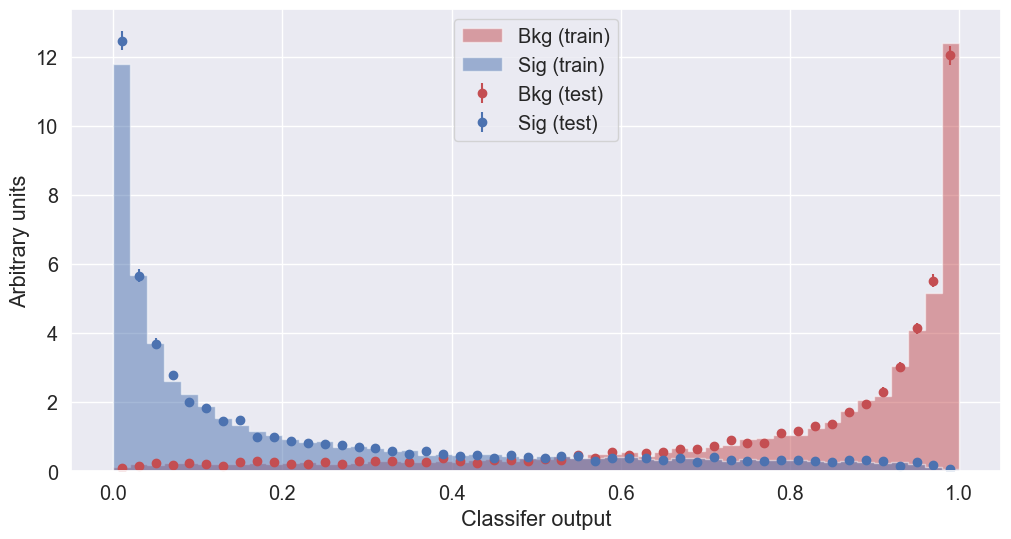

In [34]:

# Get the predictions for the training and testing samples

decisions = []
for X, y in ((x_train, y_train), (x_test, y_test)):

  # Use the outcome to select the truth information (>0.5 or <0.5)
  d1 = model.predict_proba(X[y == '998'])[:, 1]
  d2 = model.predict_proba(X[y == '-999'])[:, 1]
  decisions += [d1, d2]

# Use this for the histogram ranges
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low, high)


print(decisions)
# Make a plot of the training sample predictions
bins = 50
plt.figure(figsize=(12, 6))
plt.hist(decisions[0],
          color='r', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Bkg (train)')
plt.hist(decisions[1],
          color='b', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Sig (train)')


# Make a plot with error bars for the testing samples
hists, bins = np.histogram(decisions[2],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hists)
err = np.sqrt(hists * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.errorbar(center, hists, yerr=err, fmt='o', c='r', label='Bkg (test)')

hists, bins = np.histogram(decisions[3],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hists)
err = np.sqrt(hists * scale) / scale

plt.errorbar(center, hists, yerr=err, fmt='o', c='b', label='Sig (test)')

plt.xlabel("Classifer output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')

In [35]:
#decisions
#y_test

print(y_test)

sig_bkg = np.ones_like(y_test, dtype=int)
sig_bkg[y_test=='-999'] = 0

print(sig_bkg)

41634      998
164291    -999
152062    -999
58282      998
151227    -999
          ... 
37498      998
64587      998
75474      998
14062      998
166841    -999
Name: spmode, Length: 16000, dtype: object
[1 0 0 ... 1 1 0]


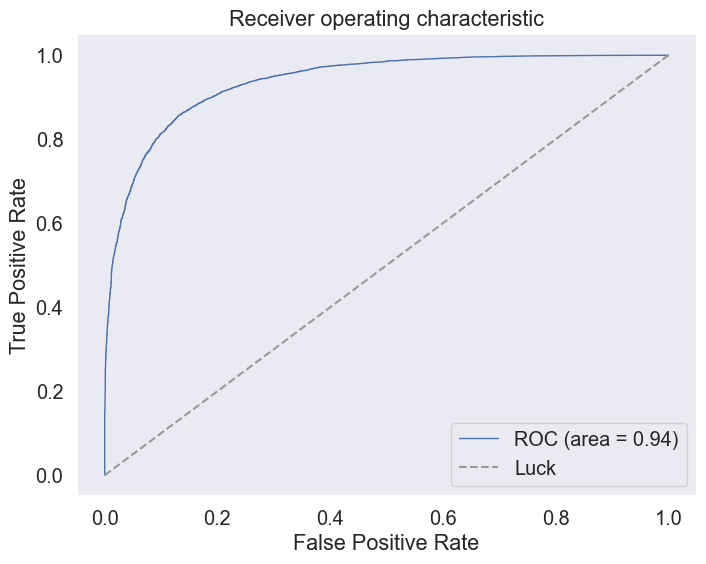

In [36]:
decisions = model.predict_proba(x_test)[:, 1]

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(sig_bkg, decisions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [37]:
y_test.unique()

array(['998', '-999'], dtype=object)

In [38]:
df_plot = x_test.copy()
print(y_test.values)
df_plot['spmode'] = y_test.values

df_plot

print(len(x_test), len(y_test))
print(len(df_plot))

['998' '-999' '-999' ... '998' '998' '-999']
16000 16000
16000


/tmp/ipykernel_256787/2793337713.py:9: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Arial.
  func(*args, **kwargs)
/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


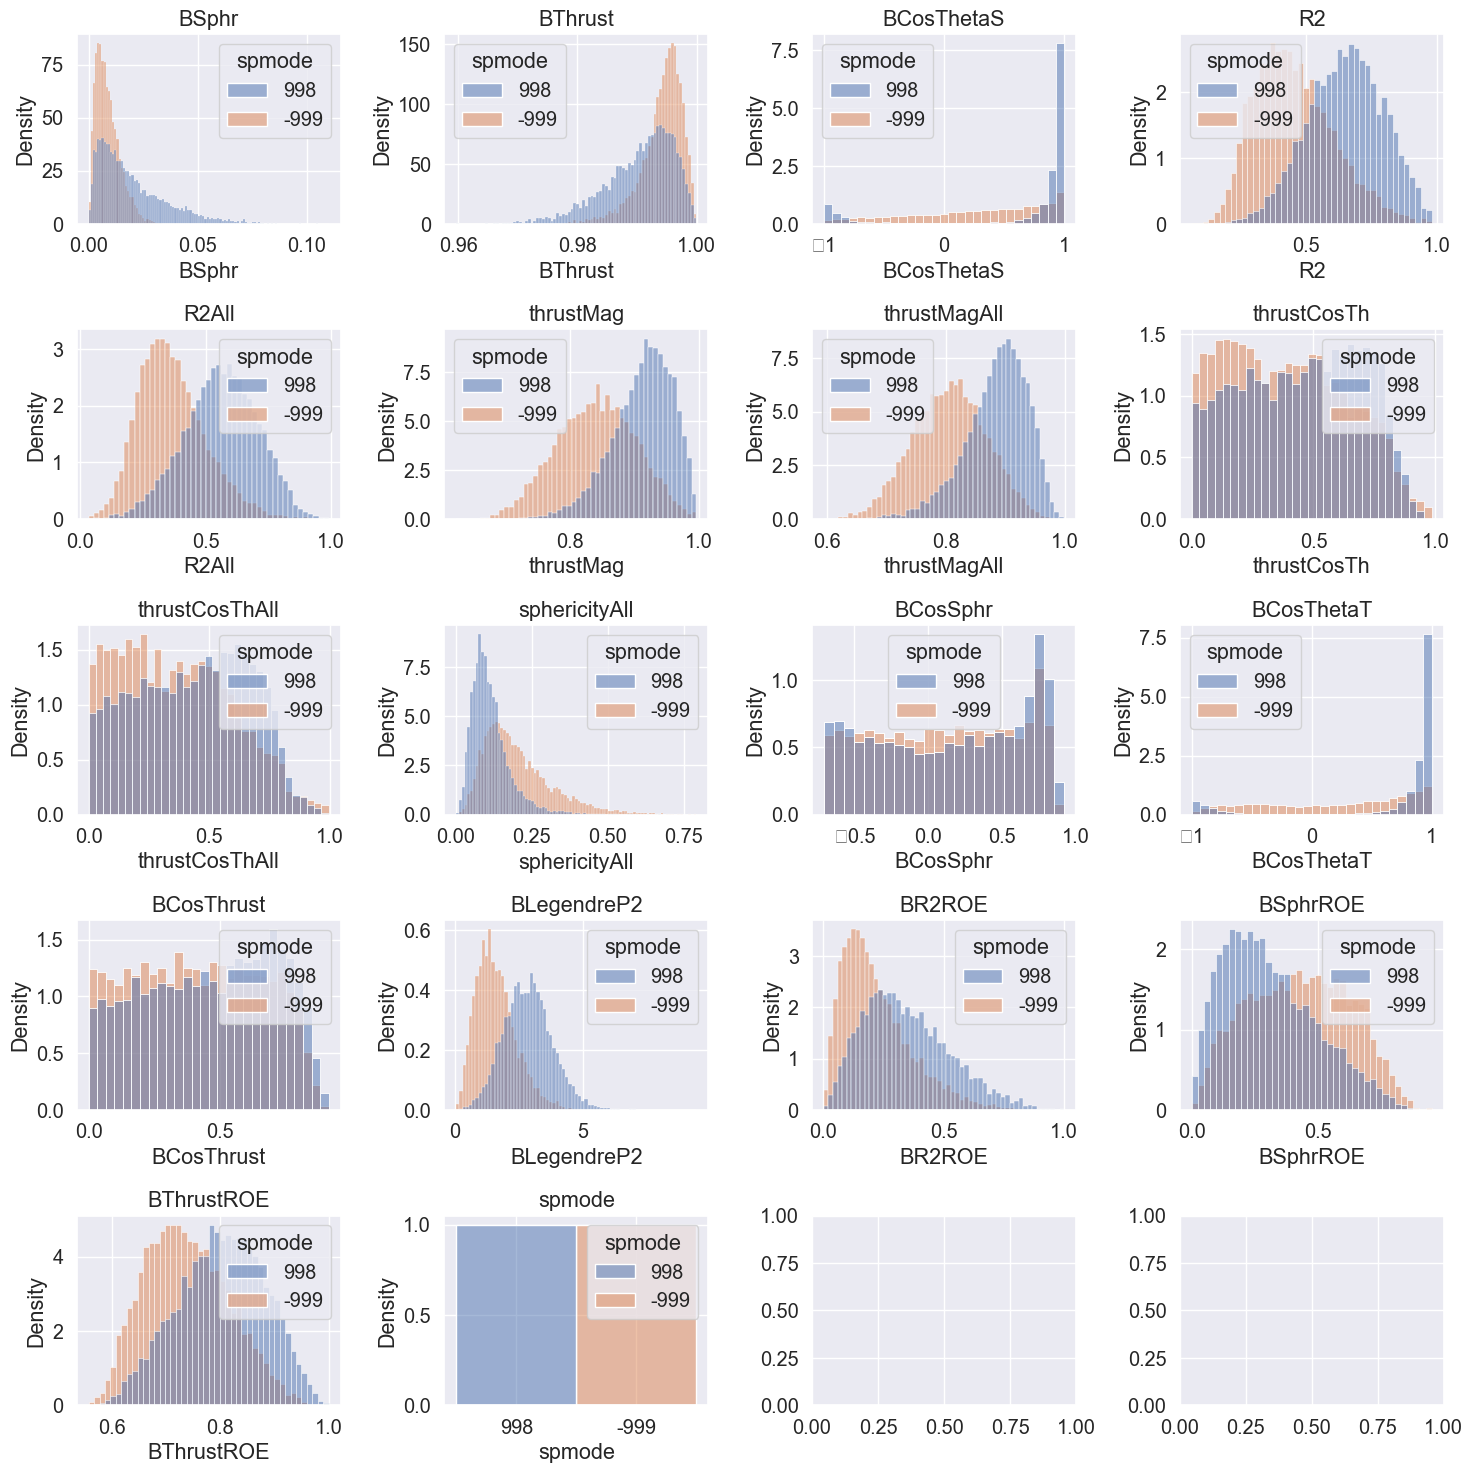

In [39]:
fig, axes = plt.subplots(nrows = 5, ncols = 4)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 15)

for ax, col in zip(axes, df_plot.columns):
  sns.histplot(df_plot, x=col, ax = ax, hue='spmode', stat='density', common_norm=False)
  ax.set_title(col)

plt.tight_layout()

# Bellis suggestions for next step

In [ ]:
mask_event= dcuts[-1]["event"] ## all cuts

tag= "FINAL_CUTS"

mask= mask_event

subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_final= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_final.to_parquet(outfilename)

df_final



In [ ]:
df_final.groupby("spmode").count()["R2"] ## R2 doesn't matter we just want to see how many of each sp mode are there

In [ ]:
mask_final_sp = df_final['spmode']=='998'
x_final_bkg= df_final[mask_final_sp].drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"]).dropna()

mask_final_sp = df_final['spmode']=='-999'
x_final_sig= df_final[mask_final_sp].drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"]).dropna()


proba_final_bkg = model.predict_proba(x_final_bkg)
proba_final_sig = model.predict_proba(x_final_sig)


proba_final_bkg

In [ ]:
model.classes_

In [ ]:
plt.hist(proba_final_bkg[:,0],bins=20, range=(0,1), alpha=0.5, label='bkg', density=True)
plt.hist(proba_final_sig[:,0],bins=20, range=(0,1), alpha=0.5, label='sig', density=True)


#plt.hist(proba_final[:,1],bins=10, range=(0,1), alpha=0.5)

plt.legend();

In [ ]:
'''
filter_sig= df["spmode"]== "-999"
filter_bkg= df["spmode"]== "998"

df_sig= df[filter_sig].dropna().sample(3000)
df_bkg= df[filter_bkg].dropna().sample(3000)


df_ML= pd.concat([df_sig,df_bkg])

x= df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass",
                       ])

y=df_ML["spmode"]

feature_names= x.columns ##disc vars
labels= y.unique() ##diff sp modes

print("Training features:")
print(feature_names)
print()

print("Labels (Outcome):")
print(labels)
print()

print("The dataset (x) is the numbers without column names---")
print("The variable y is truth info about the data (signal or bkg)")
'''

In [ ]:
#x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.06, random_state= 4)


In [ ]:
# Making the Neural Network Classifier
#model = MLPClassifier(max_iter= 50, random_state= 3, activation= "identity", solver= "adam", hidden_layer_sizes=2) #n_iter_no_change= 15)

# Training the model on the training data and labels
#model.fit(x_train, y_train)

In [ ]:
# Testing the model i.e. predicting the labels of the test data.
y_pred = model.predict(x_test)

# Evaluating the results of the model
accuracy = accuracy_score(y_test,y_pred)*100 ### returns the fraction of correctly classified samples 
confusion_mat = confusion_matrix(y_test,y_pred)

In [ ]:
#confusion_mat

# Collision data stuff

In [ ]:
print(data_collision)

In [ ]:
# This seems to not work
#BPFM= data_collision["BpostFitMes"]
#BPFDE= data_collision["BpostFitDeltaE"]

#############################################################
# Bellis edits
#############################################################
# Can we read in the Monte Carlo data?
BPFM= data["BpostFitMes"]
BPFDE= data["BpostFitDeltaE"]

# Can we plot the Monte Carlo data if we flatten it??
BPFM_sp= ak.flatten(data["BpostFitMes"])
BPFDE_sp= ak.flatten(data["BpostFitDeltaE"])

# Can we plot the collision data if we flatten it??
BPFM_coll= ak.flatten(data_collision["BpostFitMes"])
BPFDE_coll= ak.flatten(data_collision["BpostFitDeltaE"])
#############################################################

print(type(BPFM_coll))

plt.figure(figsize= (16,8))

plt.subplot(1,2,1)
plt.title("B post fit MES")
plt.hist(BPFM_coll, bins= 100, range= (3.5,5.5));
plt.xlabel("Mass [GeV/c^2]")

plt.subplot(1,2,2)
plt.title("B post fit Delta E")
plt.hist(BPFDE_coll, bins= 100, range=(-1,1));
plt.xlabel("E [GeV]")

#print(type(BPFM))

#plt.scatter(BPFM_coll, BPFDE_coll)

print(BPFM_coll)

In [ ]:
type(BPFM)
%reload_ext autoreload

In [ ]:
#bat.plot_mes_vs_DeltaE(BPFM_coll, BPFDE_coll)


import hist as hist


In [ ]:
from hist import Hist

In [ ]:
plt.figure(figsize=(8, 8))

h= Hist(
    hist.axis.Regular(400,3,7,name= "BPFM", label= "mass [GeV/c^2]", flow= True),
    hist.axis.Regular(350,-.75,1,name= "BPFMDE", label= "energy [GeV]", flow= True),
)

# normal fill
h.fill(BPFM_coll, BPFDE_coll)

h.plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

plt.xlim(5.1,5.3)
plt.ylim(-.5,.5)
plt.show()

In [ ]:
bat.plot_mes_vs_DeltaE(BPFM_coll, BPFDE_coll, region_definitions=region_definitions, draw_signal_region=True)

In [ ]:
dcuts= bat.get_final_masks(data_collision, region_definitions= region_definitions)

print([dcuts.keys()])
print()

for key in dcuts.keys():
    print(f'{key:3d} {dcuts[key]["name"]}')

dcuts[3]

In [ ]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All',\
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data_collision["spmode"])

mask_event= dcuts[-1]["event"] ## all cuts
mask= mask_event

df_dict={}
for var in subset: 
    x= data_collision[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data_collision[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out

df_out



In [ ]:

import hist as hist
from hist import Hist

plt.figure(figsize=(8, 8))

h= Hist(
    hist.axis.Regular(400,3,7,name= "BPFM", label= "mass [GeV/c^2]", flow= True),
    hist.axis.Regular(350,-.75,1,name= "BPFMDE", label= "energy [GeV]", flow= True),
)

# normal fill
h.fill(df_out["BpostFitMes"], df_out["BpostFitDeltaE"])

h.plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

plt.xlim(5.1,5.3)
plt.ylim(-.5,.5)
plt.show()


In [ ]:
bat.plot_mes_vs_DeltaE(df_out["BpostFitMes"], df_out["BpostFitDeltaE"], region_definitions=region_definitions, draw_signal_region=True)

In [ ]:
df_test= df_out.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"])

In [ ]:
print(x_test.columns)
print()

print(df_test.columns)

In [ ]:
df_test

In [ ]:
y_proba_col_sig = model.predict_proba(df_test)
y_proba_col_sig

In [ ]:
model.classes_

In [ ]:
plt.hist(y_proba_col_sig[:,0], bins=25, range=(0,1))
#plt.hist(y_proba[:,1], bins=25, range=(0,1))

In [ ]:
df_test
y_proba_col_sig[:,0]

df_temp = df_out[['BpostFitMes', 'BpostFitDeltaE']]
df_temp['proba'] = y_proba_col_sig[:,0]
df_temp

In [ ]:
df_temp[df_temp['proba']>0.5]

# Messing w MLP again 

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [ ]:
dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

print([dcuts.keys()])
print()

for key in dcuts.keys():
    print(f'{key:3d} {dcuts[key]["name"]}')

dcuts[3]

In [ ]:
#mask_event= dcuts[1]["event"]
#mask_event= dcuts[2]["event"]
mask_event= dcuts[3]["event"]
#mask_event= dcuts[4]["event"] ## individual cuts
#mask_event= dcuts[-1]["event"] ## all cuts

#mask_event= dcuts[2]["event"] & dcuts[3]["event"] & dcuts[4]["event"] ## combo of cuts

### ASK WHAT THESE MEAN
tag= "EARLY_CUT"
#tag= "FINAL_CUTS"

mask= mask_event

In [ ]:
bat.fill_new_entry_with_tag_side_B(data_collision)
data_collision["BtagSideMes"]
bat.fill_new_entry_with_tag_side_B(data)
data["BtagSideMes"]

In [ ]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out

df_out



In [ ]:
columns= df.columns


In [ ]:
feature_names= columns[1:] ##exclude spmode
print(feature_names)
df.groupby("spmode").count()["R2"] ## R2 doesn't matter we just want to see how many of each sp mode are there

In [ ]:
filter_sig= df["spmode"]== "-999"
filter_bkg= df["spmode"]== "998"

df_sig= df[filter_sig].dropna().sample(6000)
df_bkg= df[filter_bkg].dropna().sample(6000)


df_ML= pd.concat([df_sig,df_bkg])

x= df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass","BtagSideMes"])

y=df_ML["spmode"]

In [ ]:
feature_names= x.columns ##disc vars
labels= y.unique() ##diff sp modes

print("Training features:")
print(feature_names)
print()

print("Labels (Outcome):")
print(labels)
print()

print("The dataset (x) is the numbers without column names---")
print("The variable y is truth info about the data (signal or bkg)")

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.4, random_state= 4)


In [ ]:
#x_test

In [ ]:
#y_test

In [ ]:
#x_train

In [ ]:
#y_train

In [ ]:
# Making the Neural Network Classifier
model = MLPClassifier(max_iter= 300, random_state= 3, activation= "relu", solver= "adam") #n_iter_no_change= 15)
#model = RandomForestClassifier() #n_iter_no_change= 15)

# Training the model on the training data and labels
model.fit(x_train, y_train)

In [ ]:
# This seems to not work
#BPFM= data_collision["BpostFitMes"]
#BPFDE= data_collision["BpostFitDeltaE"]

#############################################################
# Bellis edits
#############################################################
# Can we read in the Monte Carlo data?
BPFM= data["BpostFitMes"]
BPFDE= data["BpostFitDeltaE"]

# Can we plot the Monte Carlo data if we flatten it??
BPFM_sp= ak.flatten(data["BpostFitMes"])
BPFDE_sp= ak.flatten(data["BpostFitDeltaE"])

# Can we plot the collision data if we flatten it??
BPFM_coll= ak.flatten(data_collision["BpostFitMes"])
BPFDE_coll= ak.flatten(data_collision["BpostFitDeltaE"])
#############################################################

print(type(BPFM_coll))

plt.figure(figsize= (16,8))

plt.subplot(1,2,1)
plt.title("B post fit MES")
plt.hist(BPFM_coll, bins= 100, range= (3.5,5.5));
plt.xlabel("Mass [GeV/c^2]")

plt.subplot(1,2,2)
plt.title("B post fit Delta E")
plt.hist(BPFDE_coll, bins= 100, range=(-1,1));
plt.xlabel("E [GeV]")

#print(type(BPFM))

#plt.scatter(BPFM_coll, BPFDE_coll)

print(BPFM_coll)

In [ ]:
import hist as hist
from hist import Hist

In [ ]:
dcuts_coll= bat.get_final_masks(data_collision, region_definitions= region_definitions)

print([dcuts_coll.keys()])
print()

for key in dcuts_coll.keys():
    print(f'{key:3d} {dcuts_coll[key]["name"]}')

dcuts_coll[3]

In [ ]:
subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All',\
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

ak_array_type= type(data_collision["spmode"])

mask_event= dcuts_coll[-1]["event"] ## all cuts
mask= mask_event

df_dict={}
for var in subset: 
    x= data_collision[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data_collision[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out

df_out

In [ ]:
merger_df= pd.DataFrame(df_out["BpostFitMes"])

merger_df

for i in range(len(merger_df["BpostFitMes"])):
    merger_df.loc[i, "event_no"] = f"event {i}"


merger_df


In [ ]:
bat.plot_mes_vs_DeltaE(df_out["BpostFitMes"], df_out["BpostFitDeltaE"], region_definitions=region_definitions, draw_signal_region=True)

In [ ]:
df_test= df_out.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"])

In [ ]:
print(x_test.columns)
print()

print(df_test.columns)
df_test

In [ ]:
y_proba_col_sig = model.predict_proba(df_test)
y_proba_col_sig

In [ ]:
plt.hist(y_proba_col_sig[:,0], bins=25, range=(0,1))
#plt.hist(y_proba[:,1], bins=25, range=(0,1))

In [ ]:
df_test
y_proba_col_sig[:,0]

df_temp = df_out[['BpostFitMes', 'BpostFitDeltaE']]

#df_temp["proba"]= df_temp.loc[:,0]

df_temp = df_temp.copy()
df_temp.loc[:, 'proba'] = y_proba_col_sig[:, 0]
df_temp

In [ ]:
big_df= df_temp.merge(merger_df, on= "BpostFitMes", how= "left")

big_df

In [ ]:
proba_mask= big_df["proba"]>0.5
big_df[proba_mask]

# KEEPING TRACK OF EVENTS 

In [ ]:
#print("SP")
#print()
tag= "EARLY_CUT"


############################### SP ###########################################

dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

#print([dcuts.keys()])
#print()

#for key in dcuts.keys():
    #print(f'{key:3d} {dcuts[key]["name"]}')
mask_event= dcuts[3]["event"]
mask= mask_event
bat.fill_new_entry_with_tag_side_B(data_collision)
bat.fill_new_entry_with_tag_side_B(data)

#subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
 #     'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
 #     'R2', 'R2All', \
 #     'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
 #     'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
 #     'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var]
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out
columns= df.columns
feature_names= columns[1:] ##exclude spmode
#print(feature_names)

#df.groupby("spmode").count()["R2"]

############################### Collision data ###########################################

subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All',\
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']

dcuts_coll= bat.get_final_masks(data_collision, region_definitions= region_definitions)

ak_array_type= type(data_collision["spmode"])

mask_event= dcuts_coll[-1]["event"] ## all cuts
mask= mask_event

df_dict={}
for var in subset: 
    x= data_collision[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data_collision[mask][var])
    df_dict[var] = x

df_col= pd.DataFrame.from_dict(df_dict)

#outfilename= f"output_variables_{tag}.parquet"
#df_col.to_parquet(outfilename)

#df= df_col

merger_df= pd.DataFrame(df_col["BpostFitMes"])

for i in range(len(merger_df["BpostFitMes"])):
    merger_df.loc[i, "event_no"] = f"event {i}"

#if verbose== True: 
#    bat.plot_mes_vs_DeltaE(df_col["BpostFitMes"], df_col["BpostFitDeltaE"], region_definitions=region_definitions, draw_signal_region=True)


################################################################################

def see_stuff(sig_samp, bkg_samp, thresh= 0.5,verbose= False,df=df, df_col=df_col):

    print("Starting -----------------------------")

    filter_sig= df["spmode"]== "-999"
    filter_bkg= df["spmode"]== "998"

    
    df_sig= df[filter_sig].dropna().sample(sig_samp)
    df_bkg= df[filter_bkg].dropna().sample(bkg_samp)
    print("Made the samples...")
    
    df_ML= pd.concat([df_sig,df_bkg])
    x= df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"])
    y=df_ML["spmode"]


    
    x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.4, random_state= 4)
    print("Split the data...")
    
    model = MLPClassifier(max_iter= 300, random_state= 3, activation= "relu", solver= "adam") #n_iter_no_change= 15)
    model.fit(x_train, y_train)
    print("Trained the model...")

    #print(f"len xtrain xtest: {len(x_train)}  {len(x_test)}")

    #print()
    #print("COLLISION")
    #print()

    
    
    #print([dcuts_coll.keys()])
    #print()
    
    #for key in dcuts_coll.keys():
        #print(f'{key:3d} {dcuts_coll[key]["name"]}')
    df_test= df_col.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"])#,"BtagSideMes"])
    y_proba_col_sig = model.predict_proba(df_test)
    print("Made the predictions of the probabilities...")
    
    if verbose== True: 
        plt.hist(y_proba_col_sig[:,0], bins=25, range=(0,1))
        
    df_temp = df_col[['BpostFitMes', 'BpostFitDeltaE']]

    df_temp = df_temp.copy()
    df_temp.loc[:, 'proba'] = y_proba_col_sig[:, 0]
    
    big_df= df_temp.merge(merger_df, on= "BpostFitMes", how= "left")
    proba_mask= big_df["proba"] > thresh
    print("Done with everything...")
    
    return big_df[proba_mask]


In [ ]:
sig_samp= 5000
bkg_samp= sig_samp

In [ ]:
see_stuff(sig_samp= sig_samp, bkg_samp= bkg_samp)

In [ ]:
see_stuff(sig_samp= 6000, bkg_samp= 6000)

In [ ]:
see_stuff(sig_samp= 5000, bkg_samp= 5000)

In [ ]:
from collections import Counter



In [ ]:
counts = Counter()

for i in range(5):  # Running the function multiple times
    results = see_stuff(sig_samp=5000, bkg_samp=5000)["event_no"]
    print(results)
    counts.update(results)  # Update the counter with the new values
    print(i)

In [ ]:
print(counts)

In [ ]:
unique_vals= list(counts.keys())
unique_amts= list(counts.values())

In [ ]:
plt.figure()
plt.bar(unique_vals, unique_amts)

In [ ]:
def visualize_counts(signal_amt, bkg_amt, ntrials=20):
    counts = Counter()
    for i in range(ntrials):  # Running the function multiple times
        results = see_stuff(sig_samp=signal_amt, bkg_samp=bkg_amt)["event_no"]
        print(i, "\n", results)
        counts.update(results)  # Update the counter with the new values
    unique_vals= list(counts.keys())
    unique_amts= list(counts.values())
    plt.figure()
    plt.bar(unique_vals, unique_amts)

In [ ]:
#sig_samp= 20000
#bkg_samp= 20000
#visualize_counts(sig_samp, bkg_samp, ntrials=5)

In [ ]:
#sig_samp= 10000
#bkg_samp= 5000
#visualize_counts(sig_samp, bkg_samp, ntrials=20)

In [ ]:
sig_samp= 5000
bkg_samp= 5000
visualize_counts(sig_samp, bkg_samp, ntrials=20)

In [ ]:
#sig_samp= 6000
#bkg_samp= 6000
#visualize_counts(sig_samp, bkg_samp, ntrials=20)

In [ ]:
#sig_samp= 6000
#bkg_samp= 6000
#visualize_counts(sig_samp, bkg_samp, ntrials=20)

# FOM 

In [40]:
#df_see_stuff = see_stuff()


def punzi_fom_nn(model_aft_train, sp_data, threshold, sp_998_df, sp_999_df, sig_disc= 4, scaling= 0.3): 
    #### FOR SP 
    combo= pd.concat([sp_998_df, sp_999_df])
    for i in threshold:
        output_df= see_stuff(sig_samp= sig_samp,bkg_samp= bkg_samp, thresh= i, verbose= False, df=combo, df_col=df_col)
        
    #### FOR COLLISION
    y_proba_col_sig = model_aft_train.predict_proba( )
    
    sp998= sp_data["spmode"]== "998"
    N_bkg = len(sp_998_df[sp998]) ## total number of background events (sp 998) 
    signal_before= len(sp_999_df)
    signal_after= len(sp_999_df)
    efficiency = signal_after/signal_before ## the accuracy of the model after training with the SP 
    fom = efficiency(threshold)/(np.sqrt(N_bkg(threshold)+sig_disc/2))

In [100]:
for key in dcuts.keys():
    print(f'{key:3d} {dcuts[key]["name"]}')


  1 cut duplicates
  2 fitting region
  3 Lambda0 cuts / nB / nLambda
  4 PID cuts
  6 antiproton cuts
 -1 all


In [41]:
sp= data["spmode"]

sp998= sp=="998"
len(data[sp998]['nTRK'])

740175

### Bellis edits

In [42]:
from analysis_variables import *


In [101]:
#print("SP")
#print()
tag= "EARLY_CUT"


subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
          'BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All',\
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']



############################### SP ###########################################

dcuts= bat.get_final_masks(data, region_definitions= region_definitions)

#print([dcuts.keys()])
#print()

#for key in dcuts.keys():
    #print(f'{key:3d} {dcuts[key]["name"]}')

mask_event = dcuts[1]["event"] & dcuts[2]["event"] & dcuts[3]["event"]

mask= mask_event

bat.fill_new_entry_with_tag_side_B(data_collision)
bat.fill_new_entry_with_tag_side_B(data)

#subset = ['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', \
 #     'BtagSideMes', 'BSphr', 'BThrust', 'BCosThetaS', \
 #     'R2', 'R2All', \
 #     'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
 #     'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
 #     'BThrustROE']

ak_array_type= type(data["spmode"])

df_dict={}
for var in subset: 
    x= data[mask][var]
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data[mask][var])
    df_dict[var] = x

df_out= pd.DataFrame.from_dict(df_dict)

outfilename= f"output_variables_{tag}.parquet"
df_out.to_parquet(outfilename)

df= df_out
columns= df.columns
feature_names= columns[1:] ##exclude spmode
#print(feature_names)

#df.groupby("spmode").count()["R2"]

############################### Collision data ###########################################

dcuts_coll= bat.get_final_masks(data_collision, region_definitions= region_definitions)

ak_array_type= type(data_collision["spmode"])

mask_event= dcuts_coll[-1]["event"] ## all cuts
mask= mask_event

df_dict={}
for var in subset: 
    x= data_collision[mask][var] ##in each event, cut on the above cuts and pull out the info from each of the variables listed above
    if type(x[0]) == ak_array_type:
        x= ak.flatten(data_collision[mask][var])
    df_dict[var] = x

df_col= pd.DataFrame.from_dict(df_dict)

#outfilename= f"output_variables_{tag}.parquet"
#df_col.to_parquet(outfilename)

#df= df_col

merger_df= pd.DataFrame(df_col["BpostFitMes"])

for i in range(len(merger_df["BpostFitMes"])):
    merger_df.loc[i, "event_no"] = f"event {i}"



/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


In [128]:
df_ML.columns

Index(['spmode', 'BpostFitMes', 'BpostFitDeltaE', 'Lambda0_unc_Mass', 'BSphr',
       'BThrust', 'BCosThetaS', 'R2', 'R2All', 'thrustMag', 'thrustMagAll',
       'thrustCosTh', 'thrustCosThAll', 'sphericityAll', 'BCosSphr',
       'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE',
       'BThrustROE'],
      dtype='object')

In [136]:

################################################################################
sig_samp = 20000
bkg_samp = 20000


filter_sig= df["spmode"]== "-999"
filter_bkg= df["spmode"]== "998"


df_sig= df[filter_sig].dropna().sample(sig_samp)
df_bkg= df[filter_bkg].dropna().sample(bkg_samp)
print("Made the samples...")
    
df_ML= pd.concat([df_sig,df_bkg])

# Drop some
columns_to_drop = ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"]
#x = df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass"])

# Drop more
columns_to_drop = ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass", \
                         "thrustCosTh", "thrustCosThAll", "BCosSphr", "BCosThrust"]
columns_to_drop = ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass", \
                         "BSphr", "BThrust"]

x = df_ML.drop(columns= columns_to_drop )

y =df_ML["spmode"]

x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.4, random_state= 4)
print("Split the data...")

print("Starting the training...")
model = MLPClassifier(max_iter= 300, random_state= 3, activation= "relu", solver= "adam") #n_iter_no_change= 15)
model.fit(x_train, y_train)
print("Trained the model...")


###########################
df_test_col= df_col.drop(columns= columns_to_drop)#,"BtagSideMes"])

y_proba_col_sig = model.predict_proba(df_test_col)
print("Made the predictions of the probabilities...")


# SP proba
filter_sig= df["spmode"]== "-999"
df_sig_test= df[filter_sig].dropna()

df_test_sp= df_sig_test.drop(columns= columns_to_drop)#,"BtagSideMes"])

y_proba_sp_sig = model.predict_proba(df_test_sp)
print("Made predictions of sp")


# SP proba
filter_bkg= df["spmode"]== "998"
df_bkg_test= df[filter_bkg].dropna()

df_test_sp_bkg= df_bkg_test.drop(columns= columns_to_drop)#,"BtagSideMes"])

y_proba_sp_bkg = model.predict_proba(df_test_sp_bkg)
print("Made predictions of sp sig")

Made the samples...
Split the data...
Starting the training...
Trained the model...
Made the predictions of the probabilities...
Made predictions of sp
Made predictions of sp sig


In [137]:
# Can use this when we pass in stuff
model.feature_names_in_

array(['BCosThetaS', 'R2', 'R2All', 'thrustMag', 'thrustMagAll',
       'thrustCosTh', 'thrustCosThAll', 'sphericityAll', 'BCosSphr',
       'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE',
       'BThrustROE'], dtype=object)

In [179]:
mask = df_ML['spmode'] == '998'
corr = df_ML[mask].drop(columns=['spmode']).corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,thrustMagAll,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
BpostFitMes,1.00,-0.00,0.01,-0.43,0.41,0.02,0.08,0.07,0.06,0.05,-0.00,0.00,-0.10,-0.01,0.01,0.00,0.02,0.03,-0.03,0.03
BpostFitDeltaE,-0.00,1.00,-0.01,-0.08,0.10,-0.01,0.05,0.05,0.04,0.04,0.01,0.01,-0.08,0.01,-0.01,0.01,-0.05,-0.00,0.01,-0.01
Lambda0_unc_Mass,0.01,-0.01,1.00,-0.00,-0.01,0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,-0.01,-0.00,-0.01,0.00,-0.01
BSphr,-0.43,-0.08,-0.00,1.00,-0.88,-0.00,-0.13,-0.12,-0.09,-0.08,-0.05,-0.06,0.21,-0.02,-0.03,-0.05,-0.02,-0.03,0.03,-0.03
BThrust,0.41,0.10,-0.01,-0.88,1.00,-0.00,0.15,0.12,0.10,0.08,0.07,0.08,-0.18,0.04,0.03,0.07,0.01,0.03,-0.03,0.03
BCosThetaS,0.02,-0.01,0.01,-0.00,-0.00,1.00,0.19,0.20,0.19,0.21,-0.20,-0.18,-0.20,0.02,0.01,-0.19,0.13,0.13,-0.14,0.14
R2,0.08,0.05,-0.01,-0.13,0.15,0.19,1.00,0.79,0.97,0.76,-0.03,-0.01,-0.67,-0.03,0.20,-0.05,0.28,0.70,-0.68,0.70
R2All,0.07,0.05,-0.01,-0.12,0.12,0.20,0.79,1.00,0.78,0.97,-0.14,-0.10,-0.81,-0.14,0.20,-0.16,0.37,0.83,-0.75,0.82
thrustMag,0.06,0.04,-0.01,-0.09,0.10,0.19,0.97,0.78,1.00,0.79,-0.06,-0.03,-0.65,-0.04,0.20,-0.07,0.29,0.70,-0.68,0.72
thrustMagAll,0.05,0.04,-0.01,-0.08,0.08,0.21,0.76,0.97,0.79,1.00,-0.18,-0.14,-0.79,-0.15,0.19,-0.20,0.36,0.80,-0.73,0.83


In [140]:
df_ML

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
137038,-999,5.275926,0.033347,1.116136,0.007669,0.997079,0.166496,0.477863,0.102261,0.856436,...,0.862441,0.532135,0.637822,0.897303,0.456228,0.897255,1.455818,0.152215,0.468861,0.708673
165473,-999,5.286555,-0.030845,1.115175,0.001347,0.997909,0.922226,0.628165,0.478860,0.918364,...,0.112237,0.116379,0.100557,-0.280265,-0.931888,0.277067,2.950520,0.219014,0.336234,0.766870
162096,-999,5.277786,0.004000,1.116813,0.007014,0.997158,0.964565,0.575856,0.390998,0.879556,...,0.793057,0.658552,0.110293,0.797389,0.941586,0.780995,1.880693,0.165374,0.637641,0.686181
167682,-999,5.278687,0.053308,1.116317,0.008577,0.995542,0.574690,0.574685,0.405544,0.894840,...,0.638903,0.569953,0.195548,0.593343,0.213702,0.579522,1.336004,0.186258,0.291246,0.744696
167826,-999,5.280560,0.008339,1.117532,0.002922,0.997416,0.412733,0.312920,0.248516,0.800805,...,0.105702,0.011962,0.276788,0.430925,-0.439646,0.412127,1.281099,0.278380,0.319685,0.759137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,998,5.267833,-0.010415,1.117063,0.010776,0.988836,0.835960,0.499245,0.404239,0.873507,...,0.541712,0.539700,0.234764,-0.379930,0.864600,0.393862,3.032937,0.337451,0.401971,0.760175
15122,998,5.262807,0.050788,1.114289,0.014776,0.992924,0.981778,0.579975,0.570162,0.903438,...,0.265897,0.247525,0.093136,-0.229651,0.977951,0.236570,3.579232,0.300036,0.253047,0.816767
10492,998,5.264280,-0.115461,1.115604,0.009024,0.994062,0.944372,0.918922,0.873886,0.985972,...,0.593416,0.605204,0.038283,0.639378,0.984750,0.634902,1.735347,0.746999,0.023925,0.945130
92798,998,5.235186,-0.016387,1.116577,0.025982,0.990980,0.959025,0.790033,0.550081,0.959473,...,0.832876,0.757577,0.145526,0.898679,0.968055,0.890557,3.289071,0.529408,0.146772,0.887113


In [141]:
df

,spmode,BpostFitMes,BpostFitDeltaE,Lambda0_unc_Mass,BSphr,BThrust,BCosThetaS,R2,R2All,thrustMag,...,thrustCosTh,thrustCosThAll,sphericityAll,BCosSphr,BCosThetaT,BCosThrust,BLegendreP2,BR2ROE,BSphrROE,BThrustROE
0,998,5.263783,-0.189936,1.116111,0.005330,0.998314,0.464635,0.454394,0.419195,0.829818,...,0.277930,0.397070,0.110201,-0.509205,-0.366883,0.520370,1.097943,0.169009,0.411743,0.715501
1,998,5.211709,-0.054256,1.115692,0.003054,0.998590,-0.988520,0.500206,0.449933,0.866854,...,0.670107,0.709401,0.100613,0.711723,0.991103,0.733522,4.020535,0.203065,0.444210,0.740848
2,998,5.205639,-0.095738,1.114520,0.039430,0.982052,0.994756,0.925238,0.887027,0.987027,...,0.140156,0.148416,0.030029,0.117417,0.992060,0.108286,2.378769,0.887218,0.003017,0.972584
3,998,5.244567,-0.052588,1.114744,0.013351,0.990498,0.523062,0.591105,0.356842,0.860644,...,0.750955,0.793746,0.166007,0.821093,0.909180,0.820298,1.454894,0.160212,0.600114,0.653028
4,998,5.215815,0.050270,1.117489,0.011017,0.989456,0.943788,0.683442,0.658670,0.928303,...,0.118271,0.146456,0.063063,0.026921,-0.924347,0.016714,3.028776,0.520410,0.222310,0.883328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168889,-999,5.279527,0.033336,1.114953,0.004968,0.996235,0.691058,0.385213,0.315803,0.831228,...,0.039638,0.030412,0.217225,0.138832,-0.656168,0.116068,1.932471,0.185726,0.344503,0.739092
168890,-999,5.275526,0.000239,1.114017,0.012021,0.995474,0.085707,0.341070,0.222305,0.782304,...,0.619186,0.570975,0.248629,0.589459,0.070907,0.586688,0.550932,0.229605,0.322895,0.774997
168891,-999,5.276882,-0.037394,1.114870,0.012876,0.988566,-0.329969,0.341776,0.277969,0.806673,...,0.064506,0.102459,0.355454,0.119290,0.336818,0.115901,0.931738,0.612370,0.093815,0.910479
168892,-999,5.278979,0.003463,1.116391,0.005293,0.997421,-0.586439,0.337755,0.299489,0.795328,...,0.621333,0.599540,0.179411,-0.453241,0.365380,0.461186,1.063949,0.203228,0.327322,0.766174


In [142]:
#y_proba_col_sig
#### COLLISIONS
df_temp = df_col[['BpostFitMes', 'BpostFitDeltaE']]

df_temp = df_temp.copy()
df_temp.loc[:, 'proba'] = y_proba_col_sig[:, 0]

big_df= df_temp.merge(merger_df, on= "BpostFitMes", how= "left")
#proba_mask= big_df["proba"] > thresh
#print("Done with everything...")

#return big_df[proba_mask]

big_df

outfilename = 'DATAFRAME_MES_DELTAE_PROB_collision.parquet'
big_df.to_parquet(outfilename)


######## SP

df_temp = df_sig_test[['BpostFitMes', 'BpostFitDeltaE', 'spmode']]

df_temp = df_temp.copy()
df_temp.loc[:, 'proba'] = y_proba_sp_sig[:, 0]

big_df_sp = df_temp.copy()

big_df_sp

outfilename = 'DATAFRAME_MES_DELTAE_PROB_sig.parquet'
big_df_sp.to_parquet(outfilename)



######## SP bkg

df_temp = df_bkg_test[['BpostFitMes', 'BpostFitDeltaE', 'spmode']]

df_temp = df_temp.copy()
df_temp.loc[:, 'proba'] = y_proba_sp_bkg[:, 0]

big_df_sp_bkg = df_temp.copy()

big_df_sp_bkg

outfilename = 'DATAFRAME_MES_DELTAE_PROB_bkg.parquet'
big_df_sp_bkg.to_parquet(outfilename)


#big_df_sp = df_temp.merge(merger_df, on= "BpostFitMes", how= "left")
#proba_mask= big_df["proba"] > thresh
#print("Done with everything...")

#return big_df[proba_mask]

#big_df_sp

#df_temp

(-0.2, 0.2)

/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Arial.
  func(*args, **kwargs)
/home/bellis/micromamba/envs/pyhep311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


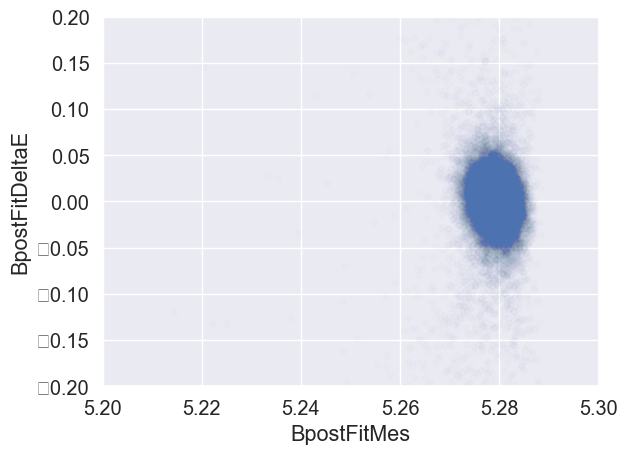

In [143]:
#big_df.plot.scatter(x='BpostFitMes', y='BpostFitDeltaE')

big_df_sp.plot.scatter(x='BpostFitMes', y='BpostFitDeltaE', alpha=0.01)

plt.xlim(5.2, 5.3)
plt.ylim(-0.2, 0.2)

In [144]:
region_definitions

{'Area': ['Fitting area', 'Signal area'],
 'signal MES': [5.27, 5.3],
 'fitting MES': [5.2, 5.3],
 'signal DeltaE': [-0.07, 0.07],
 'fitting DeltaE': [-0.2, 0.2],
 'sideband 1 DeltaE': [0.07, 0.14],
 'sideband 2 DeltaE': [-0.14, -0.07],
 'sideband MES': [5.27, 5.3],
 'inference': [[5.27, 5.3, -0.07, 0.07],
  [5.27, 5.3, -0.2, -0.07],
  [5.27, 5.3, 0.07, 0.2],
  [5.25, 5.27, -0.2, 0.0],
  [5.25, 5.27, 0.0, 0.2],
  [5.23, 5.25, -0.2, 0.0],
  [5.23, 5.25, 0.0, 0.2],
  [5.2, 5.23, -0.2, 0.0],
  [5.2, 5.23, 0.0, 0.2]],
 'Lambda0 mass': [1.112683, 1.1186829999999999],
 'Lambda0 flightlen': 1.0}

In [145]:
meslo = region_definitions['signal MES'][0]
meshi = region_definitions['signal MES'][1]

delo = region_definitions['signal DeltaE'][0]
dehi = region_definitions['signal DeltaE'][1]


messidelo = region_definitions['sideband MES'][0]
messidehi = region_definitions['sideband MES'][1]

desidelo1 = region_definitions['sideband 1 DeltaE'][0]
desidehi1 = region_definitions['sideband 1 DeltaE'][1]

desidelo2 = region_definitions['sideband 2 DeltaE'][0]
desidehi2 = region_definitions['sideband 2 DeltaE'][1]

print(desidelo2, desidehi2)

-0.14 -0.07


In [146]:
mes = big_df['BpostFitMes']
de = big_df['BpostFitDeltaE']

mask = (mes>messidelo) & (mes<messidehi) & (de>desidelo1) & (de<desidehi1)

nsi1 = len(big_df[mask])

mask = (mes>messidelo) & (mes<messidehi) & (de>desidelo2) & (de<desidehi2)

big_df[mask]

nsi2 = len(big_df[mask])


print(nsi1, nsi2)

201 294


In [147]:

fom_dict = {}
fom_dict['thresh'] = []
fom_dict['nbkg1'] = []
fom_dict['nbkg2'] = []
fom_dict['nsig'] = []

for thresh in np.arange(0,1,0.01):
    #print(thresh)
    fom_dict['thresh'].append(thresh)

    # Collision
    mask_thresh = big_df['proba'] > thresh

    mes = big_df['BpostFitMes']
    de = big_df['BpostFitDeltaE']
    
    mask1 = (mes>messidelo) & (mes<messidehi) & (de>desidelo1) & (de<desidehi1)
    mask2 = (mes>messidelo) & (mes<messidehi) & (de>desidelo2) & (de<desidehi2)
    
    nbkg1 = len(big_df[mask_thresh & mask1])
    nbkg2 = len(big_df[mask_thresh & mask2])
    
    fom_dict['nbkg1'].append(nbkg1)
    fom_dict['nbkg2'].append(nbkg2)
    
    # SP
    mask_thresh = big_df_sp['proba'] > thresh

    mes = big_df_sp['BpostFitMes']
    de = big_df_sp['BpostFitDeltaE']
    
    mask = (mes>meslo) & (mes<meshi) & (de>delo) & (de<dehi)
    
    nsig = len(big_df_sp[mask_thresh & mask])
    
    fom_dict['nsig'].append(nsig)


fom_df = pd.DataFrame.from_dict(fom_dict)

fom_df

,thresh,nbkg1,nbkg2,nsig
0,0.00,201,294,36359
1,0.01,200,293,36355
2,0.02,195,289,36340
3,0.03,187,280,36295
4,0.04,182,267,36215
...,...,...,...,...
95,0.95,0,3,9945
96,0.96,0,1,8386
97,0.97,0,0,6669
98,0.98,0,0,4841


In [148]:
fom_df['nbkg'] = fom_df['nbkg1'] + fom_df['nbkg2']

In [149]:
fom_df['sig_pct'] = fom_df['nsig'] / fom_df['nsig'].iloc[0]

<Axes: xlabel='thresh'>

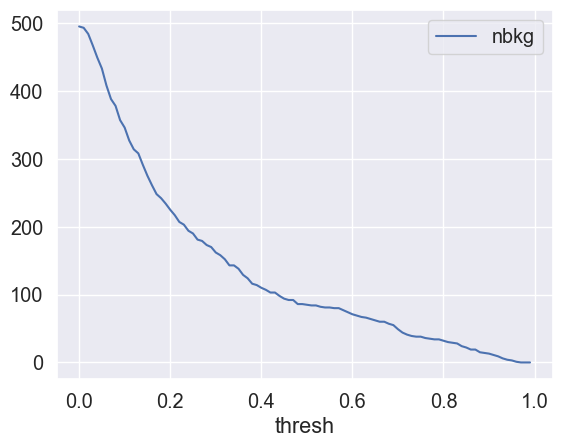

In [150]:
#fom_df.plot(x='thresh',y='sig_pct')

fom_df.plot(x='thresh',y='nbkg')

In [151]:
sigma = 4.0

fom_df['fom'] = fom_df['sig_pct'] / (np.sqrt(fom_df['nbkg']) + sigma/2.0)

Text(0.5, 0, 'threshold')

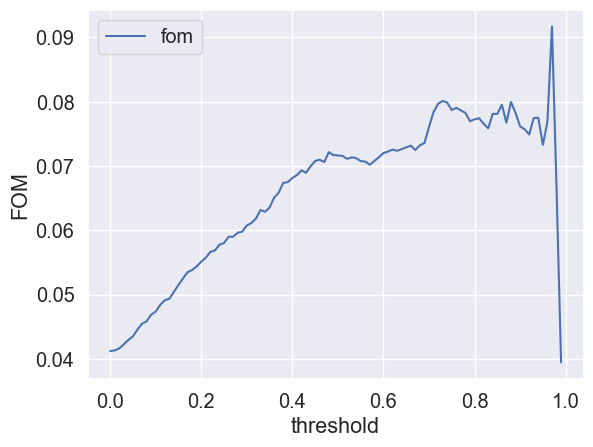

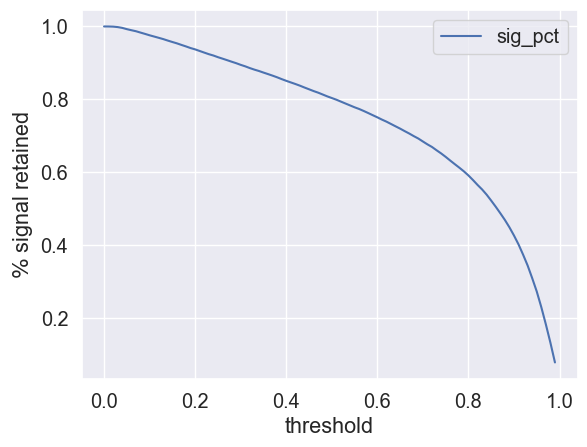

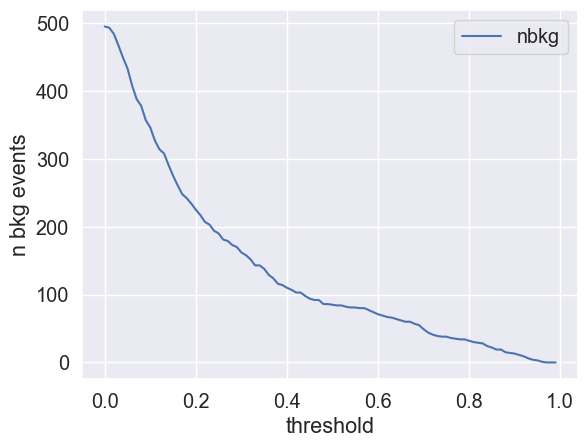

In [152]:
fom_df.plot(x='thresh', y='fom')
plt.ylabel("FOM")
plt.xlabel("threshold")


fom_df.plot(x='thresh',y='sig_pct')
plt.ylabel("$\%$ signal retained")
plt.xlabel("threshold")


fom_df.plot(x='thresh',y='nbkg')
plt.ylabel("n bkg events")
plt.xlabel("threshold")


In [155]:
fom_max = fom_df['fom'].max()

print(fom_max)

filter = fom_df['fom'] == fom_max

fom_df[filter]

0.09171044308149288


,thresh,nbkg1,nbkg2,nsig,nbkg,sig_pct,fom
97,0.97,0,0,6669,0,0.183421,0.09171


In [156]:
big_df

,BpostFitMes,BpostFitDeltaE,proba,event_no
0,5.274736,-0.126853,0.918962,event 0
1,5.236844,-0.133317,0.302581,event 1
2,5.253302,0.194015,0.125993,event 2
3,5.271616,0.152471,0.786302,event 3
4,5.240542,0.118487,0.192846,event 4
...,...,...,...,...
7994,5.239419,0.185526,0.524440,event 7664
7995,5.285107,0.139227,0.053799,event 7665
7996,5.234437,0.030877,0.279419,event 7666
7997,5.219249,-0.081498,0.608668,event 7667


<Axes: >

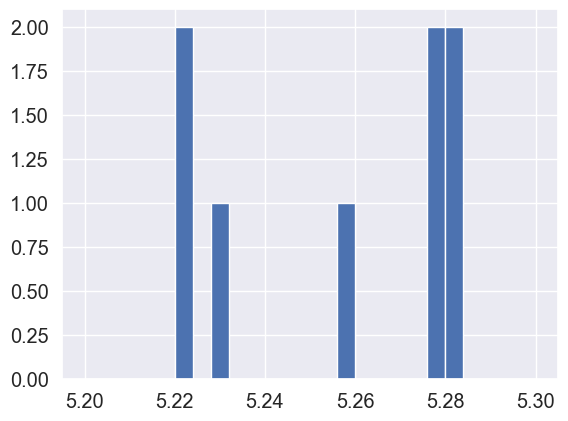

In [171]:
mask_de = (big_df['BpostFitDeltaE'] < 0.05) & (big_df['BpostFitDeltaE'] > -0.05)

mask_prob = big_df['proba'] > 0.97

mask = mask_prob & mask_de

big_df[mask]['BpostFitMes'].hist(bins=25, range=(5.2,5.3))

<Axes: >

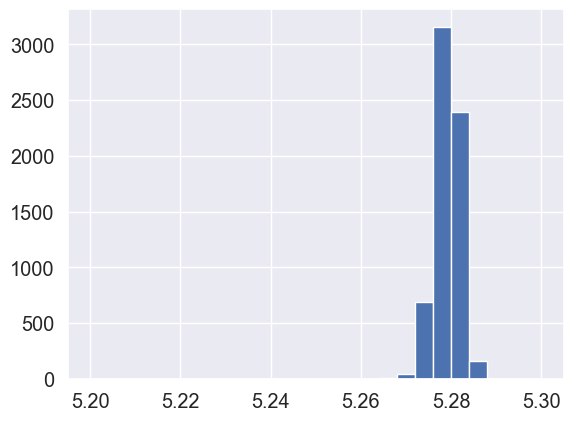

In [170]:
mask_de = (big_df_sp['BpostFitDeltaE'] < 0.05) & (big_df_sp['BpostFitDeltaE'] > -0.05)

mask_prob = big_df_sp['proba'] > 0.97

mask = mask_de & mask_prob

big_df_sp[mask]['BpostFitMes'].hist(bins=25, range=(5.2,5.3))


#df_sig

<Axes: >

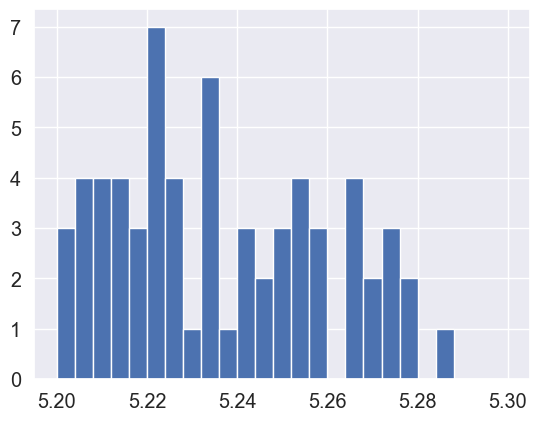

In [172]:
mask_de = (big_df_sp_bkg['BpostFitDeltaE'] < 0.05) & (big_df_sp_bkg['BpostFitDeltaE'] > -0.05)

mask_prob = big_df_sp_bkg['proba'] > 0.97

mask = mask_de & mask_prob

big_df_sp_bkg[mask]['BpostFitMes'].hist(bins=25, range=(5.2,5.3))


#df_sig

# TRYING TO BIAS/OVERFIT/UNDERFIT

In [ ]:
'''
print(f"Accuracy for Neural Network is: {accuracy:.2f}")
print("Confusion Matrix")
print(confusion_mat)

tot_correct= confusion_mat[1][1] + confusion_mat[0][0]
tot_wrong= confusion_mat[1][0] + confusion_mat[0][1]

#print(tot_correct/(tot_correct+tot_wrong))

## The accuracy score is the total number classified correctly over the total number of classifications 
'''

In [ ]:
'''
# Turn this into a dataframe
matrix_df = pd.DataFrame(confusion_mat)

# Plot the result
fig, ax = plt.subplots(figsize=(10,7))

sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")

#labels = df['target_names'].tolist()
#labels = ['998', '-999'] # NEED TO FIX THIS SO IT IS NOT HARDCODED

# Formatting details here
# Set axis titles
ax.set_title('Confusion Matrix - MLP')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(labels, rotation = 0)
plt.show()
'''

In [ ]:
#from sklearn.model_selection import cross_val_score
#from sklearn import svm

In [ ]:
#clf= svm.SVC(kernel="linear", C=1, random_state=2).fit(x_train,y_train)

In [ ]:
#print(f"CV score: {clf.score(x_test,y_test):.2f}")

In [ ]:
'''
# Get the predictions for the training and testing samples

decisions = []
for X, y in ((x_train, y_train), (x_test, y_test)):

  # Use the outcome to select the truth information (>0.5 or <0.5)
  d1 = model.predict_proba(X[y == '998'])[:, 1]
  d2 = model.predict_proba(X[y == '-999'])[:, 1]
  decisions += [d1, d2]

# Use this for the histogram ranges
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low, high)

# Make a plot of the training sample predictions
bins = 50
plt.figure(figsize=(12, 6))
plt.hist(decisions[0],
          color='r', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Bkg (train)')
plt.hist(decisions[1],
          color='b', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Sig (train)')


# Make a plot with error bars for the testing samples
hist, bins = np.histogram(decisions[2],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Bkg (test)')

hist, bins = np.histogram(decisions[3],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Sig (test)')

plt.xlabel("Classifer output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
'''

## BIAS

In [ ]:
'''
filter_sig= df["spmode"]== "-999"
filter_bkg= df["spmode"]== "998"

df_sig= df[filter_sig].dropna().sample(3000)
df_bkg= df[filter_bkg].dropna().sample(3000)


df_ML= pd.concat([df_sig,df_bkg])

x= df_ML.drop(columns= ["spmode","BpostFitMes","BpostFitDeltaE","Lambda0_unc_Mass",\
                       'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll',\
                        'sphericityAll', 'BCosSphr', 'BCosThetaT', 'BCosThrust', \
                        'BLegendreP2','BR2ROE', 'BSphrROE', 'BThrustROE',"R2",\
                        "BtagSideMes", "BSphr"
                       ])

y=df_ML["spmode"]

feature_names= x.columns ##disc vars
labels= y.unique() ##diff sp modes

print("Training features:")
print(feature_names)
print()

print("Labels (Outcome):")
print(labels)
print()

print("The dataset (x) is the numbers without column names---")
print("The variable y is truth info about the data (signal or bkg)")
'''

In [ ]:
#x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.06, random_state= 4)


In [ ]:
# Making the Neural Network Classifier
#model = MLPClassifier(max_iter= 50, random_state= 3, activation= "identity", solver= "adam", hidden_layer_sizes=3) #n_iter_no_change= 15)

# Training the model on the training data and labels
#model.fit(x_train, y_train)

In [ ]:
'''
# Testing the model i.e. predicting the labels of the test data.
y_pred = model.predict(x_test)

# Evaluating the results of the model
accuracy = accuracy_score(y_test,y_pred)*100 ### returns the fraction of correctly classified samples 
confusion_mat = confusion_matrix(y_test,y_pred)
'''

In [ ]:
'''
print(f"Accuracy for Neural Network is: {accuracy:.2f}")
print("Confusion Matrix")
print(confusion_mat)

tot_correct= confusion_mat[1][1] + confusion_mat[0][0]
tot_wrong= confusion_mat[1][0] + confusion_mat[0][1]

#print(tot_correct/(tot_correct+tot_wrong))

## The accuracy score is the total number classified correctly over the total number of classifications 
'''

In [ ]:
'''
# Turn this into a dataframe
matrix_df = pd.DataFrame(confusion_mat)

# Plot the result
fig, ax = plt.subplots(figsize=(10,7))

sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")

#labels = df['target_names'].tolist()
#labels = ['998', '-999'] # NEED TO FIX THIS SO IT IS NOT HARDCODED

# Formatting details here
# Set axis titles
ax.set_title('Confusion Matrix - MLP')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(labels, rotation = 0)
plt.show()
'''

In [ ]:
#clf= svm.SVC(kernel="linear", C=1, random_state=2).fit(x_train,y_train)

In [ ]:
#print(f"CV score: {clf.score(x_test,y_test):.2f}")

In [ ]:
'''
# Get the predictions for the training and testing samples

decisions = []
for X, y in ((x_train, y_train), (x_test, y_test)):

  # Use the outcome to select the truth information (>0.5 or <0.5)
  d1 = model.predict_proba(X[y == '998'])[:, 1]
  d2 = model.predict_proba(X[y == '-999'])[:, 1]
  decisions += [d1, d2]

# Use this for the histogram ranges
low = min(np.min(d) for d in decisions)
high = max(np.max(d) for d in decisions)
low_high = (low, high)

# Make a plot of the training sample predictions
bins = 50
plt.figure(figsize=(12, 6))
plt.hist(decisions[0],
          color='r', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Bkg (train)')
plt.hist(decisions[1],
          color='b', alpha=0.5, range=low_high, bins=bins,
          histtype='stepfilled', density=True,
          label='Sig (train)')


# Make a plot with error bars for the testing samples
hist, bins = np.histogram(decisions[2],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Bkg (test)')

hist, bins = np.histogram(decisions[3],density=True,
                          bins=bins, range=low_high)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Sig (test)')

plt.xlabel("Classifer output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
'''

In [ ]:
df_temp[df_temp['proba']>0.5]